<hr style="border: 1px solid black; width: 100%; margin-left: 0">


<div style="text-align:right"> <b>University of Padua - Department of Physics and Astronomy<b> </div> 
<div style="text-align:right"> <strong> Degree course: </strong> Physics of Data</div>
<div style="text-align:right"><strong>Course: </strong>Information Theory and Inference<b> </div>
<div style="text-align:right"><strong>Year: </strong>2024-2025<b> </div>
    

#### Students:
- Bertinelli Gabriele - 2103359 - gabriele.bertinelli@studenti.unipd.it
- Lovato Matteo - 2104269 - matteo.lovato.3@studenti.unipd.it

    
<strong>Exam Date</strong>: February, 21st 2025
    
<center>
    
# Approximate Bayes Computation: application on the SIR model
<center>
<hr style="border: 1px solid black; width: 100%; margin-left: 0">   

In [2]:
from PIL import Image

## SIR Model

The **SIR model** is a mathematical tool to model the spreading of infectuous diseases. It is a stochastic model, including three possible states for a population:
- _susceptible_ (S): individuals who have not suffered of the disease yet;
- _infected_ (I): individuals who are currently suffering of the disease; 
- _recovered_ (R): individuals who have recovered o have died from the disease. 

SIR model describes the flow of individuals from S to I and then from I to R by a set of ordinary differential equations:
$$
\begin{cases}
\frac{dS(t)}{dt} &= -\beta S(t)P(t) \\
\frac{dI(t)}{dt} &= \beta S(t)P(t) - \gamma I (t) \\
\frac{dR (t)}{dt} &= \gamma I (t)
\end{cases}
$$
where $P(t)=I(t)/N$ is the proportion of infectuous individuals at time $t$, $\beta$ is the transmission rate parameter and $\gamma$ the removal rate parameter. The sum of $S(t)$, $I(t)$ and $R(t)$ gives at any moment the total population $N$. <u>**The goal of our work is to infer the parameters $\beta$ and $\gamma$**</u>.

We derived the model used in this analysis by the one proposed in [Gu J., Yin G. (2022)](https://www.nature.com/articles/s41598-022-25473-y).  
Let $\Delta I = (\Delta I_1,...,\Delta I_\text{T})^T $ and $\Delta R = (\Delta R_1,...,\Delta R_\text{T})^T $  be sequences of daily reported numbers of newly infected (confirmed) cases and removed cases respectively. Given the initial state of the population $(S_0,I_0,R_0)$, we write the discrete-time stochastic SIR model as follows:
$$
\begin{equation*}
\begin{cases}
\Delta I_t \sim \text{Binomial}\left(S_{t-1}, 1 - \exp(-\beta_t P_{t-1})\right) \\
\Delta R_t \sim \text{Binomial}\left(I_{t-1}, \gamma_t\right) \\
S_t = S_{t-1} - \Delta I_t \\
I_t = I_{t-1} + \Delta I_t - \Delta R_t \\
R_t = R_{t-1} + \Delta R_t
\end{cases}
\end{equation*}
$$

### "Observed" data
The shapes of the priors are the one considered in [Gu J., Yin G. (2022)](https://www.nature.com/articles/s41598-022-25473-y):

$$ \beta \sim Exp(\lambda=0.1)$$
$$\gamma \sim Beta(\alpha=0.01, \beta=1)$$

We generated a timeseries, i.e. our observed data, at fiducial parameter values

$$ \beta = 0.01 $$
$$ \gamma = 0.1 $$

The parameter values were chosen to be in line with typical values found in the literature.

Being it a stochastic model, the shape of the distribution is not fixed, rather it will have an "intrinsic" noise which will impact on the acceptance rate of the samples. However, usually this appears to be of small magnitude.

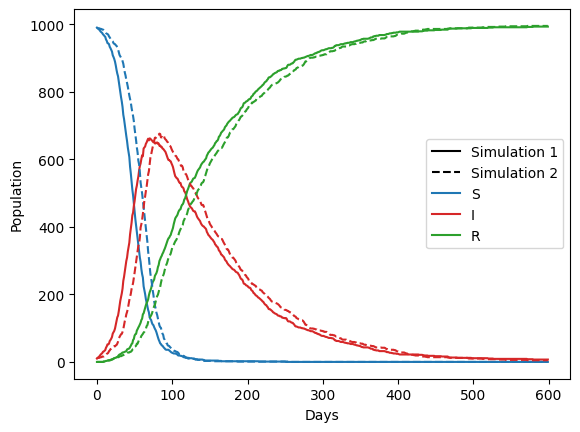

In [16]:
Image.open('./py_code/plot/SIR_sims.png')

## Approximate Bayesian Computation (ABC)

In statistical inference, there exist cases in which the likelihood $\mathcal{L}=\pi(d|\theta)$ may be unavailable, either because of mathematical or computational reasons.  
The ABC algorithm uses our ability to simulate physical process to bypass the necessity of a $\mathcal{L}$:

<!-- - We start with the usual Bayes theorem $\pi(\theta|d) \propto \pi(d|\theta)\,\pi(\theta)$
- It’s useful sometimes to include simulations to the real dataset and the theorem modifies as  
  $\pi(\theta,s|d) \propto \pi(d|\theta,s)\,\pi(s|\theta)\,\pi(\theta)$, where $\pi(s|\theta)$ is the <u>simulation model</u>.
- We end up to an approximate $\mathcal{L}$-free posterior $\Rightarrow$  
  $\pi_{LF}(\theta|d) \propto \pi(\theta)\,\int\pi(d|\theta,s)\,\pi(s|\theta) ds = \pi(\theta)\,\pi(d|\theta)$, since $\pi(d|\theta,s) \equiv \delta^D(d-s)$, i.e. the distance between the real data and the simulation. -->

It is based on the following elements:

- a simulator, or forward model
- prior distributions over the input parameters $\pi(\theta)$
- a distance function $\varrho(\mathcal{D}_1, \mathcal{D}_2)$
- a threshold $\varepsilon$

<!-- The main idea behind the ABC algorithm can be summarized in three main steps:

1. draw a large number of parameter values $\bm{\theta}^i$, from the prior distribution
2. $\forall \bm{\theta}^i$ generate a simulation $\mathcal{D}^i_S$ and calculate the distance between the observed to the simulated catalogues: $\rho_i=\rho(\mathcal{D}, \mathcal{D}^i_S)$
3. approximate the posterior distribution using the fraction of $\bm{\theta}^i$ with smallest associated distances. -->

### ABC - rejection sampler

Firstly, we implemented the "likelihood-free rejection sampler" algorithm in [Marin et al. (2011)](https://doi.org/10.1007/s11222-011-9288-2).

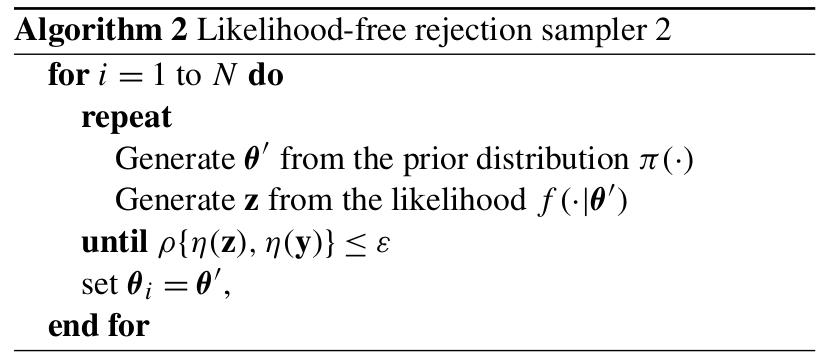

In [3]:
Image.open('./py_code/plot/abc_algo.png', )

In this case we selected the Euclidean distance, normalized by the population size just to have a more "manageable" number for the threshold $\varepsilon$.  
We run the algorithm for $\varepsilon = \{20, 18, 16, 14, 10, 6, 5, 3, 2, 1\}$. The algorithm stops when the number of accepted samples is 10.000.

<!-- ```c
// Compute distance between observed and simulated data (S,I,R arrays).
// d_S, d_I, d_R are normalized by population N.
void distance(int N, int ndays, int *obs_S, int *obs_I, int *obs_R, 
              int *sim_S, int *sim_I, int *sim_R,
              double *d_S, double *d_I, double *d_R) {
    *d_S = compute_norm(sim_S, obs_S, ndays) / N;
    *d_I = compute_norm(sim_I, obs_I, ndays) / N;
    *d_R = compute_norm(sim_R, obs_R, ndays) / N;
}
``` -->

#### **Computational Analysis**

As we decrease the threshold, the computation time increase ~ exponentially as the average number of trials (in order to find an accepted parameter), while the acceptance rate decreases:  
for $\varepsilon = \{3,2,1\}$ it's below $0.03\%$.

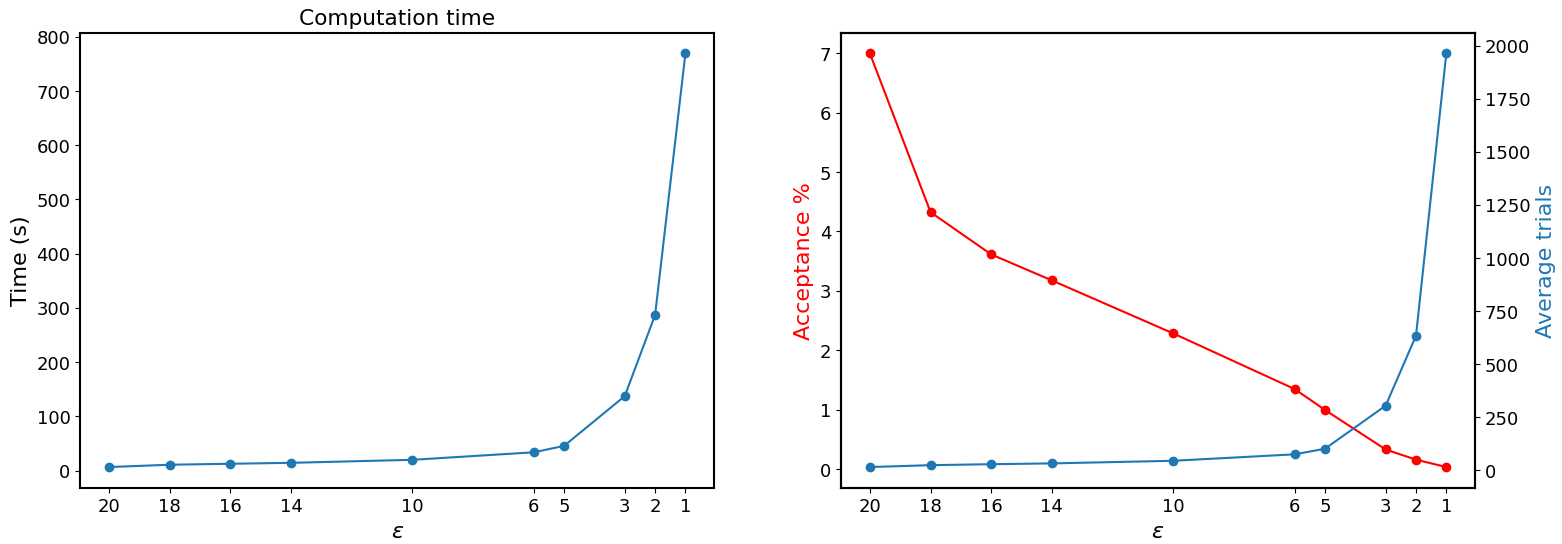

In [4]:
Image.open('./py_code/plot/comp_stats.png')

We want to see if there's a "sweet spot" for the threshold $\varepsilon$, the computation time and the inferred parameter median.  
A threshold of 14 seems to be a good compromise. We can also see that $\varepsilon=5$ could be also a good value. Thus we will consider $\epsilon = 14, 5$ for our analysis.  
The computation time for $\varepsilon=14$ is $\simeq 14.2\,s$, while for $\varepsilon=5$ is $\simeq 45.5\,s$.

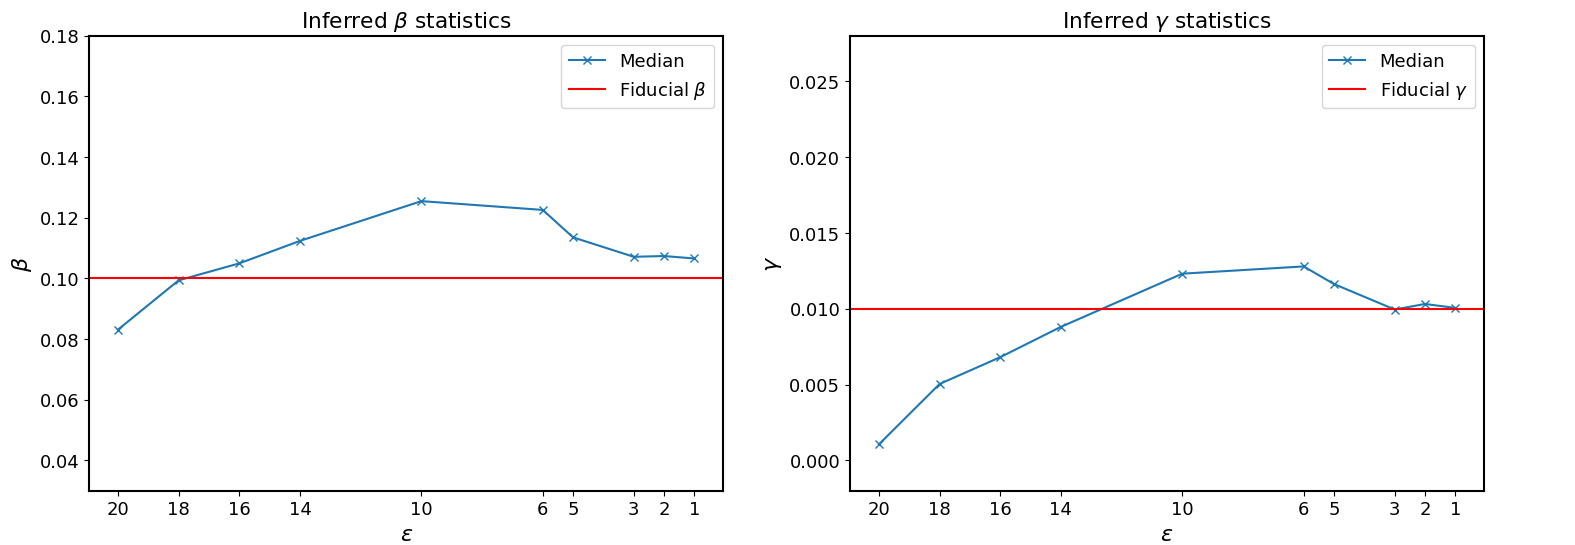

In [17]:
Image.open('./py_code/plot/inferred_median.png')

The relative error for $\varepsilon = 14$ it's $\sim 12\%$, while for $\varepsilon = 5$ it's $\sim 15\%$.

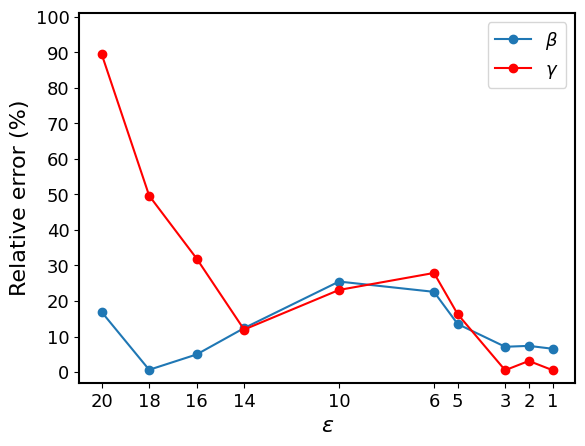

In [10]:
Image.open('./py_code/plot/rel_error.png')

#### **Statistical Inference**

Here we have a comparison of the distributions of the accepted samples. Note that for $\varepsilon = 14$ the sample are distributed on a broader region.  
Another observation is that, although the two threshold lead to a similar relative error and have similar computation time, the distribution of data sampled with $\varepsilon=5$ has a narrower 95% credible interval.

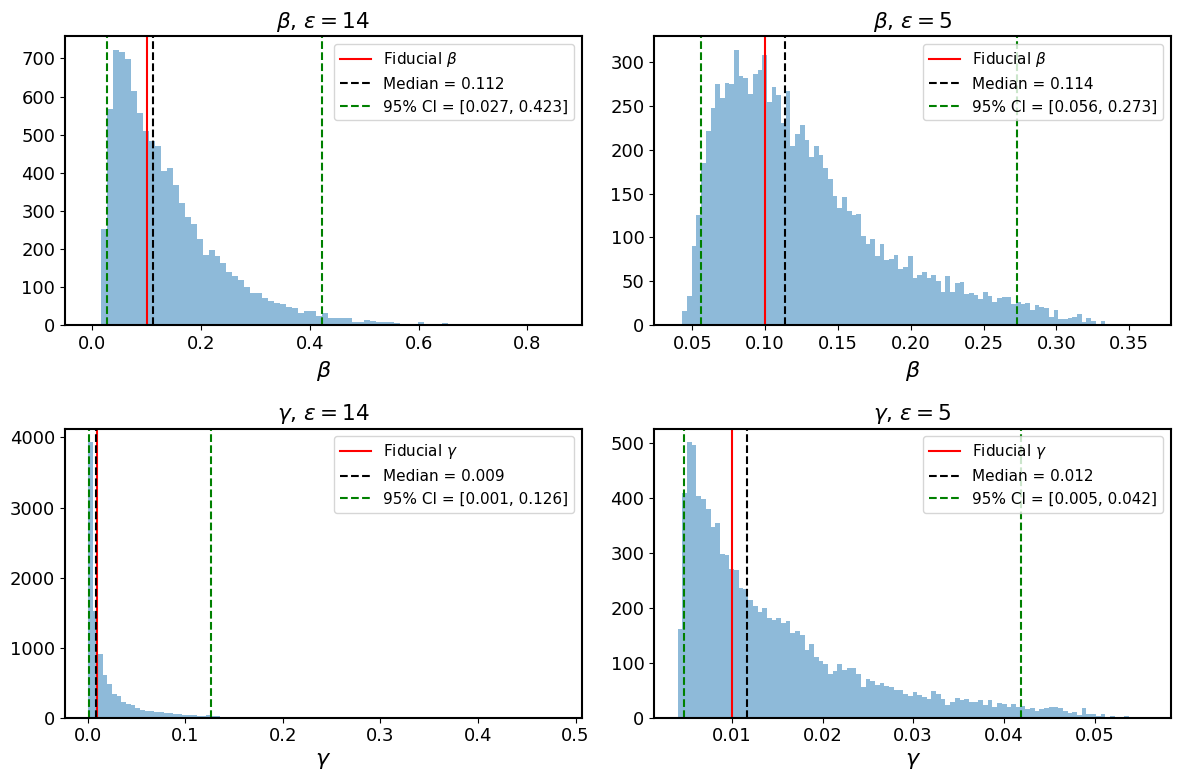

In [11]:
Image.open('./py_code/plot/hist_plot.png')

We can consider also $\varepsilon=1$. The computation time is $\simeq 12.8$ minutes, but we can reach a relative error on $\beta$ of $6.6\%$ and of $0.53\%$ on $\gamma$.  The 95% CI is also narrower.

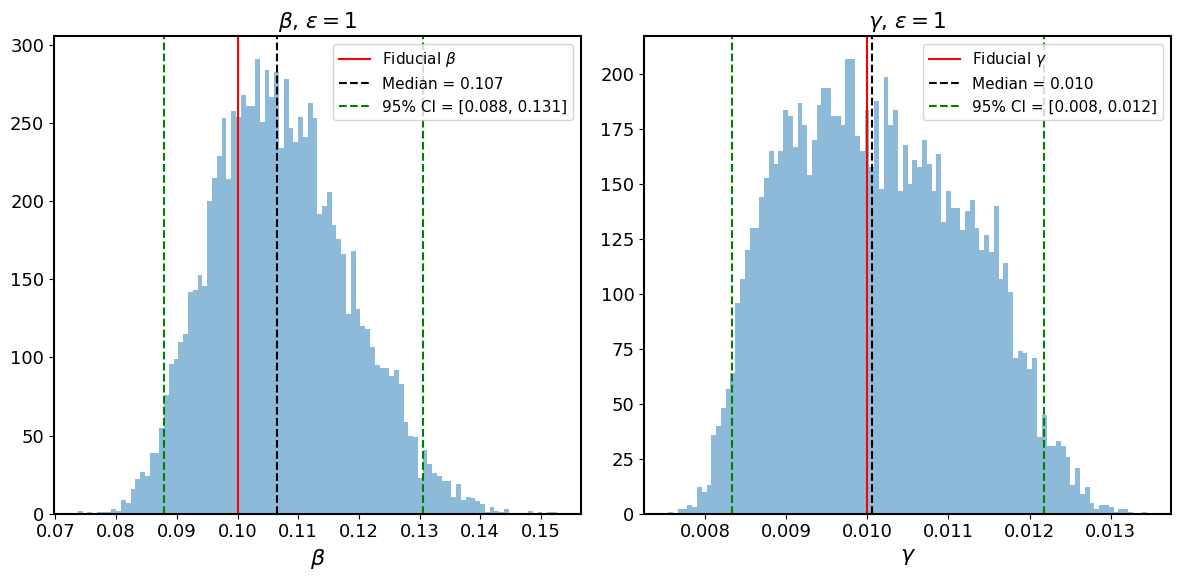

In [16]:
Image.open('./py_code/plot/hist_01.png')

<img src='./py_code/plot/evolution_abc.gif' width="500" align="center">

## ABC - Population Monte Carlo

The disadvantage of the ABC rejection sampler is that the acceptance rate is generally low. To avoid this problem and the fact that long MCMC chains may get stuck in regions of low probability for long periods of time, the so called **ABC Sequential Monte Carlo (ABC-SMC)** was introduced.  

ABC-SMC is an algorithm where successive steps towards the posterior are achieved by applying an importance (or weighted) sampling in the set of parameters values whose distances satisfy a given initial threshold.  

The goal of PMC-ABC is to start with $\theta_0 \sim \pi_0$ and then resample through a series of intermediate auxiliary distribution until you get a sample from $\pi_\epsilon=\mathbb{I}(\rho(d|S)\le\epsilon_T)$  
$\begin{cases}
\pi_0(\theta) \rightarrow \text{prior} & \\
\pi_t(\theta) = \text{intermediate distr} \equiv \pi_0\mathbb{I}(\rho(d|S)\le\epsilon_t) \;\,\text{with}\;\, \epsilon_1\gt...\gt\epsilon_t\gt...\gt\epsilon_T &\\
\pi_T(\theta)\equiv\pi_{\epsilon_T} \Rightarrow \text{target}
\end{cases}$  

The algorithm implemented is from [Toni et al. (2009)](https://doi.org/10.1098/rsif.2008.0172):

<!-- - Algorithm:
1. Initialize $\epsilon_1,...,\epsilon_T$ and set $t=0$ ($t$ is the population indicator)
2. 
    1. Set $i=1$ ($i$ is the particle indicator)
    2. If $t=0$: sample $\theta^{**}\sim\pi_0$ (do this for the number of particles you want); set $w=1$  
    If $t\not=0$: sample $\theta^*$ from previous population at time $t-1$ $(\{\theta^i_{t-1}\})$  
            Sample via SIS with weight at $t-1$  
            After resampling, perturb with $K$ to obtain $\theta^{**}\sim K_t(\theta|\theta^*)$  
                    -) If $\pi_0(\theta^{**})=0$ (”outside prior”) go back to (2.2)  
                    -) Otherwise, simulate dataset $S^*\sim \pi_S(S|\theta^{**})$  
        
        $$
        \begin{cases}
        \text{If}\,\; \rho(d|S^*)\le\epsilon_t \;\, \text{accept} \\
        \text{Otherwise go back to (2.b)}
        \end{cases}
        $$
        
3. 
    1. Set $\theta^i_t=\theta^{**}$, which is distributed according to the auxiliary distribution
    2. Calculate weights for SIS
        
        $$
        \text{unnormalized}\;\,w_t^i=\begin{cases}
        1 &\text{if}\;\,t=0 \\
        \frac{\pi_0(\theta_t^i)}{\sum_i w^i_{t-1}K_t(\theta^i_{t-1},\theta^i_t)} &\text{otherwise}
        \end{cases}
        $$
        
        If $i\lt N$ then $i=i+1$ and go to (2.2)
        
4. Normalize the weights
    
    If $t\lt T$ then $t=t+1$ and go to (2.1) -->

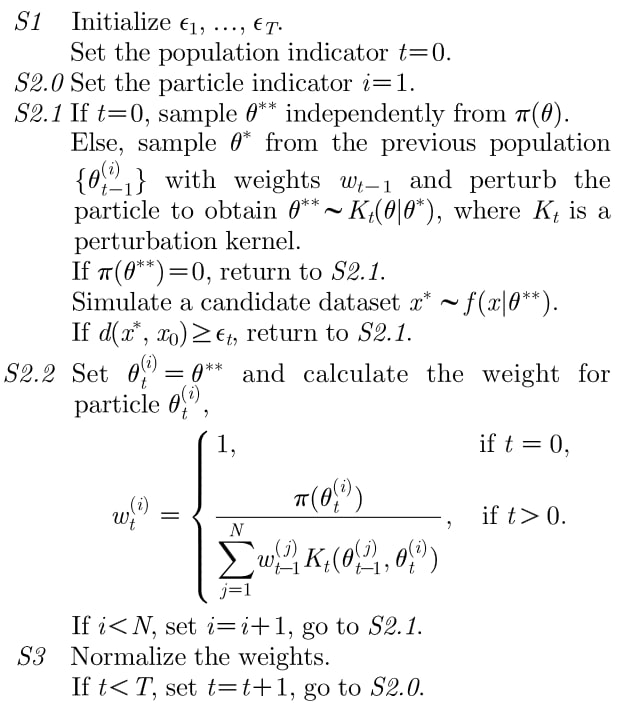

In [18]:
Image.open('./py_code/plot/abc_smc.png')

Here, we choose the perturbation kernel $K_t$ to be a **Gaussian random walk**, with zero mean and standard deviation as the standard deviation of the population at the previous generation.  
Furthermore we decided to iteratively update the threshold $\varepsilon$ by choosing the **75th percentile** of the distances array between observed data and simulation. As for the ABC rejection algorithm, we choose to use as distance measure the Euclidean distance normalized by the population size.

#### **Computational Analysis**

#### **Statistical Inference**

# TODO
tabella con risultati
We do not report the plots here, but if we consider $\varepsilon=1$